In [1]:
# change pwd to parent directory
import os

cwd = os.getcwd()
os.chdir(os.path.dirname(cwd))

In [2]:
import numpy as np
from src.self_exciting.hawkes_regression import SelfExcitingLogisticRegression as SELR
from src.self_exciting.hawkes_regression import compute_time_series_groups_idx

In [19]:
from generate_fake_seq import create_fake_seq

n_individuals = int(10**3)  # Number of individuals
max_events_per_individual = 10 # Maximum number of events per individual
true_alpha, true_gamma, true_beta_c, true_delta_c, true_beta_s, true_delta_s = (
    -2,
    [-0.5, 0.5],
    3, 0.1,
    3, 0.1
)

times, events, covariates, individuals = create_fake_seq(n_individuals, max_events_per_individual, true_alpha,
                            true_gamma, true_beta_c, true_delta_c, true_beta_s,
                            true_delta_s)

Proportion of nonzero events: 0.19848996622292867


In [20]:
positive_obs_in_groups_idx = compute_time_series_groups_idx(events_all=events, individuals_all=individuals)

In [21]:
# instantiate model
model = SELR(
    max_iter=int(10**4),
    time_types=['discrete', 'continuous'],
    ignore_errors=True,
    tol=1e-8
    )
simple_model = SELR(
    max_iter=int(10**4),
    time_types=[],
    ignore_errors=True
    )

In [2]:
import numpy as np
np.arange(0,10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [22]:
model.fit(times_all=times, events_all=events, individuals_all=individuals, covariates_all=covariates)

[-0.18160173  0.09918738 -0.94488177  0.50702622  0.07628663 -0.34053657
  0.57685741]
Parameters: -1.3959862281003692, [-0.02294946 -0.0144772 ], 0.5070262173496132, 0.07628662643855644, -0.34053656700181567, 0.5768574068568086
Number of parameters: 7


In [25]:
# compare true and estimated parameters
true_params = [true_alpha, true_gamma, true_beta_c, true_delta_c, true_beta_s, true_delta_s]

alpha, gamma, beta_c, delta_c, beta_s, delta_s = model.load_params()
estimated_params = [alpha, gamma, beta_c, delta_c, beta_s, delta_s]

for param_par in zip(true_params, estimated_params):
    print(f'{param_par}')

(-2, -1.3959862281003692)
([-0.5, 0.5], array([-0.02294946, -0.0144772 ]))
(3, 0.5070262173496132)
(0.1, 0.07628662643855644)
(3, -0.34053656700181567)
(0.1, 0.5768574068568086)


In [26]:
simple_model.fit(
    times_all=times,
    events_all=events,
    individuals_all=individuals,
    covariates_all=covariates
    )

Parameters: -1.3957309846028598, [-0.02291664 -0.01446366], 0, 0, 0, 0
Number of parameters: 3


In [27]:
from src.self_exciting.hawkes_regression import likelihood_ratio_test
def flatten(list_of_lists_and_floats):
    flattened = []
    for item in list_of_lists_and_floats:
        if isinstance(item, list) or isinstance(item, np.ndarray):
            flattened.extend(flatten(item))
        else:
            flattened.append(item)
    return np.array(flattened)

print('Likelihood ratio test')
print(likelihood_ratio_test(fullmodel=model, submodel=simple_model))
print('')
print(f'Simple model nll: {simple_model.nll_}')
print(f'Full model nll: {model.nll_}')

opt_nll = model.log_likelihood(
    params=flatten(true_params),
    events_all=events,
    times_all=times,
    covariates_all=covariates,
    positive_obs_in_groups_idx=positive_obs_in_groups_idx
    )
print(f'Optimal likelihood {opt_nll}')

Likelihood ratio test
(False, 0.9999999996497844, 5.293179310683627e-05)

Simple model nll: 2507.652028968673
Full model nll: 2507.6520025027767
Optimal likelihood 2766.1841832760883


In [28]:
params = np.random.rand(1 + covariates.shape[1] + 4)  # alpha, gamma..., beta_c, delta_c, beta_s, delta_s
perturbed_params = params.copy()
perturbed_params[-3] += 0.01  # Perturb delta_c
perturbed_ll = model.log_likelihood(
    params=perturbed_params,
    events_all=events,
    times_all=times,
    covariates_all=covariates,
    positive_obs_in_groups_idx=positive_obs_in_groups_idx
)

print("Initial log-likelihood:", model.log_likelihood(params, events, times, covariates, positive_obs_in_groups_idx))
print("Perturbed log-likelihood (delta_c + 0.01):", perturbed_ll)

Initial log-likelihood: 5457.419307648344
Perturbed log-likelihood (delta_c + 0.01): 5457.419307648344


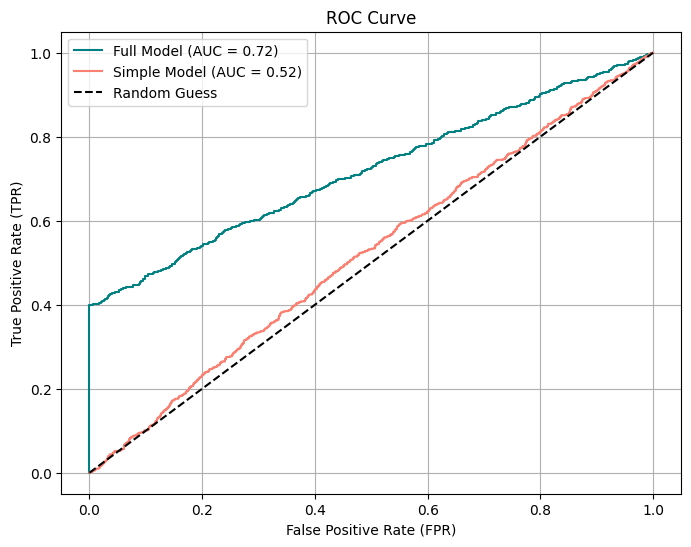

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Big model ROC curve
predicted_probs = model.predict_proba(times, covariates, events, individuals, events)
fpr, tpr, thresholds = roc_curve(events, predicted_probs)
auc_score = roc_auc_score(events, predicted_probs)

# small model ROC curve 
predicted_probs_small = simple_model.predict_proba(times, covariates, events, individuals, events)
fpr_small, tpr_small, thresholds_small = roc_curve(events, predicted_probs_small)
auc_score_simple = roc_auc_score(events, predicted_probs_small)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Full Model (AUC = {auc_score:.2f})", color='teal')
plt.plot(fpr_small, tpr_small, label=f"Simple Model (AUC = {auc_score_simple:.2f})", color='salmon')
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend(loc="best")
plt.grid(True)
plt.show()